In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification,make_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression , Ridge
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')

In [17]:
def k_fold_split(X,y,n_splits=5,shuffle=True,random_state=42):
    n_samples=len(X)
    indices=np.arange(n_samples)

    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(indices)

    fold_sizes=np.full(n_splits,n_samples//n_splits,dtype=int)
    fold_sizes[:n_samples%n_splits]+=1

    current=0
    for fold_size in fold_sizes:
        test_idx=indices[current:current+fold_size]
        train_idx=np.concatenate([indices[:current],indices[current+fold_size:]])
        yield train_idx, test_idx
        current+=fold_size


def cross_validate_manual(X,y,model,n_splits=5):

    scores=[]
    for train_idx,test_idx in k_fold_split(X,y,n_splits):
        X_train,X_test=X[train_idx],X[test_idx]
        y_train,y_test=y[train_idx],y[test_idx]

        model.fit(X_train,y_train)
        score=model.score(X_test,y_test)
        scores.append(score)

    return np.array(scores)


X,y=make_classification(n_samples=1000,n_features=20,random_state=42)
model=LogisticRegression(max_iter=1000)

manual_scores=cross_validate_manual(X,y,model,n_splits=5)
sklearn_scores=cross_val_score(model,X,y,cv=5)

print("=== K-Fold Cross-Validation ===")
print(f"Manual CV: {manual_scores.mean():.4f} (+/- {manual_scores.std():.4f})")
print(f"Sklearn CV: {sklearn_scores.mean():.4f} (+/- {sklearn_scores.std():.4f})")






=== K-Fold Cross-Validation ===
Manual CV: 0.8630 (+/- 0.0075)
Sklearn CV: 0.8670 (+/- 0.0258)


In [ ]:

def stratified_kfold_split(X, y, n_splits=5, random_state=42):
"""Stratified K-Fold - maintains class distribution"""
    np.random.seed(random_state)
    classes, y_indices = np.unique(y, return_inverse=True)
    n_classes = classes.shape[0]
    
    class_counts = np.bincount(y_indices)
    class_indices = np.split(np.argsort(y_indices, kind='mergesort'),
                              np.cumsum(class_counts)[:-1])
    
    for c_idx in class_indices:
        np.random.shuffle(c_idx)
    
    for fold in range(n_splits):
        test_idx = []
        for c_idx in class_indices:
            fold_size = len(c_idx) // n_splits
            start = fold * fold_size
            end = (fold + 1) * fold_size if fold < n_splits - 1 else len(c_idx)
            test_idx.extend(c_idx[start:end])
        
        train_idx = np.setdiff1d(np.arange(len(y)), test_idx)
        yield train_idx, test_idx


X_imb, y_imb = make_classification(n_samples=1000, n_classes=2, weights=[0.9, 0.1], 
                                    n_features=20, random_state=42)

print("\n=== Stratified K-Fold (Imbalanced: 90-10 split) ===")
for i, (train_idx, test_idx) in enumerate(stratified_kfold_split(X_imb, y_imb, n_splits=5)):
    train_dist = np.bincount(y_imb[train_idx]) / len(train_idx)
    test_dist = np.bincount(y_imb[test_idx]) / len(test_idx)
    print(f"Fold {i+1} - Train: {train_dist[1]:.3f} | Test: {test_dist[1]:.3f}")


=== Stratified K-Fold (Imbalanced: 90-10 split) ===
Fold 1 - Train: 0.104 | Test: 0.101
Fold 2 - Train: 0.104 | Test: 0.101
Fold 3 - Train: 0.104 | Test: 0.101
Fold 4 - Train: 0.104 | Test: 0.101
Fold 5 - Train: 0.101 | Test: 0.113



=== Generating Learning Curves ===
Saved: learning_curves.png


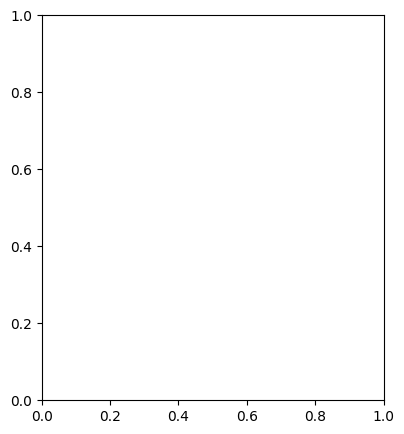

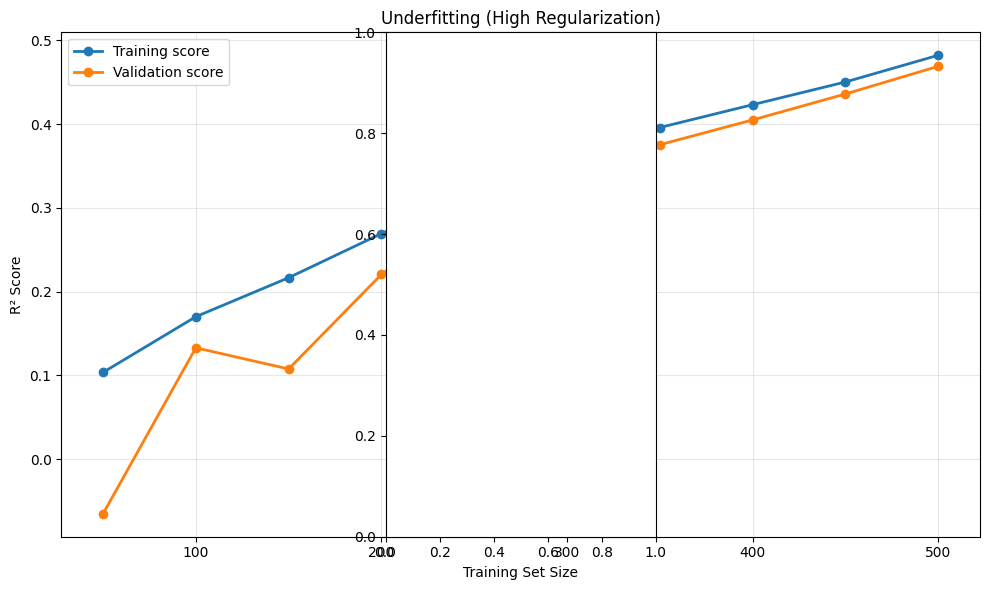

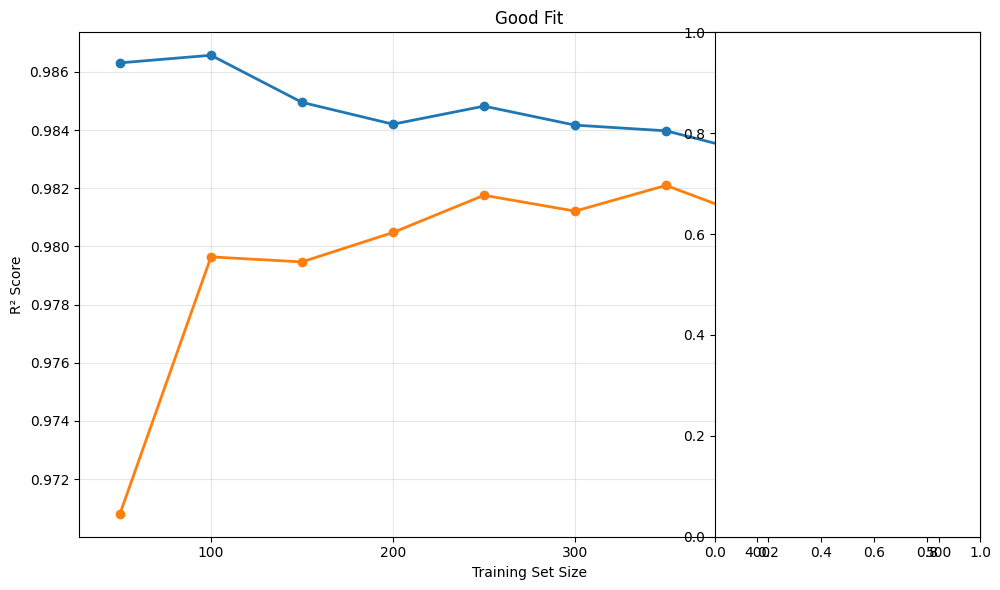

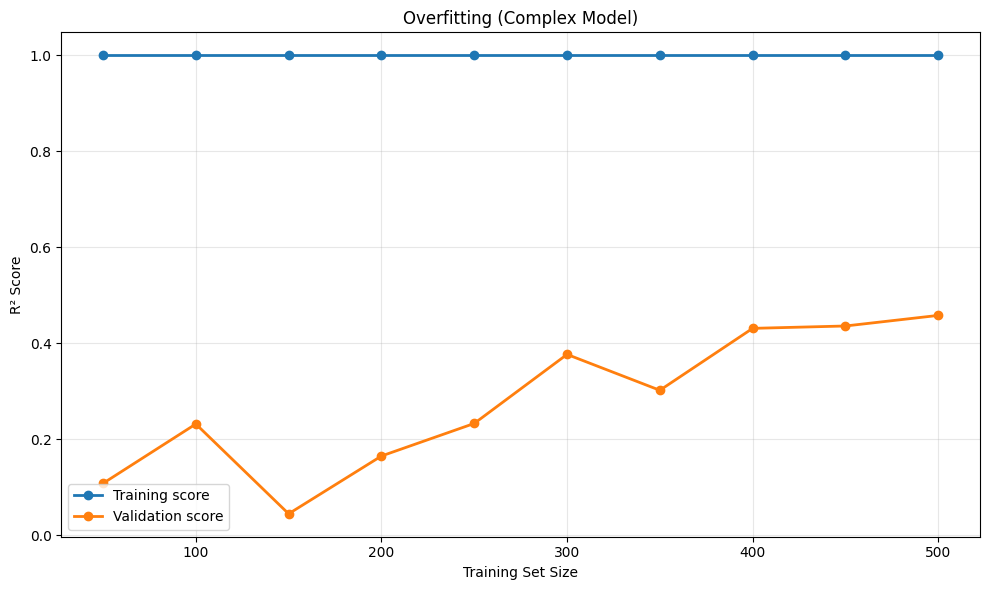

In [16]:
def plot_learning_curves(X, y, model, title="Learning Curves"):
    """Generate learning curves to diagnose bias/variance"""
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_scores = []
    val_scores = []
    
    for size in train_sizes:
        n_samples = int(size * len(X))
        scores_train = []
        scores_val = []
        
        for train_idx, val_idx in k_fold_split(X[:n_samples], y[:n_samples], n_splits=5):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model.fit(X_train, y_train)
            scores_train.append(model.score(X_train, y_train))
            scores_val.append(model.score(X_val, y_val))
        
        train_scores.append(np.mean(scores_train))
        val_scores.append(np.mean(scores_val))
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes * len(X), train_scores, 'o-', label='Training score', linewidth=2)
    plt.plot(train_sizes * len(X), val_scores, 'o-', label='Validation score', linewidth=2)
    plt.xlabel('Training Set Size')
    plt.ylabel('R² Score')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return train_scores, val_scores


X_reg, y_reg = make_regression(n_samples=500, n_features=10, noise=20, random_state=42)

print("\n=== Generating Learning Curves ===")
plt.figure(figsize=(15, 5))

# Underfit model (high bias)
plt.subplot(1, 3, 1)
model_underfit = Ridge(alpha=1000)
plot_learning_curves(X_reg, y_reg, model_underfit, "Underfitting (High Regularization)")

# Good fit
plt.subplot(1, 3, 2)
model_good = Ridge(alpha=1)
plot_learning_curves(X_reg, y_reg, model_good, "Good Fit")

# Overfit model (high variance)
plt.subplot(1, 3, 3)
model_overfit = DecisionTreeRegressor(max_depth=20)
plot_learning_curves(X_reg, y_reg, model_overfit, "Overfitting (Complex Model)")

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=100, bbox_inches='tight')
print("Saved: learning_curves.png")

In [18]:
def bias_variance_decomposition(X, y, model, n_bootstraps=50):
    """Empirical bias-variance decomposition"""
    n_samples = len(X)
    predictions = np.zeros((n_bootstraps, n_samples))
    
    for i in range(n_bootstraps):
        # Bootstrap sample
        idx = np.random.choice(n_samples, n_samples, replace=True)
        X_boot, y_boot = X[idx], y[idx]
        
        model.fit(X_boot, y_boot)
        predictions[i] = model.predict(X)
    
    # Bias = (mean prediction - true value)^2
    mean_pred = predictions.mean(axis=0)
    bias_squared = ((mean_pred - y) ** 2).mean()
    
    # Variance = average variance of predictions
    variance = predictions.var(axis=0).mean()
    
    # Total error
    mse = ((predictions - y) ** 2).mean()
    
    return bias_squared, variance, mse

print("\n=== Bias-Variance Decomposition ===")
models = [
    ("Linear (High Bias)", Ridge(alpha=100)),
    ("Optimal", Ridge(alpha=1)),
    ("Complex (High Variance)", DecisionTreeRegressor(max_depth=10))
]

for name, model in models:
    bias2, var, mse = bias_variance_decomposition(X_reg, y_reg, model, n_bootstraps=30)
    print(f"{name:25} | Bias²: {bias2:8.2f} | Variance: {var:8.2f} | MSE: {mse:8.2f}")



=== Bias-Variance Decomposition ===
Linear (High Bias)        | Bias²:   976.74 | Variance:    16.57 | MSE:   993.31
Optimal                   | Bias²:   369.21 | Variance:     8.69 | MSE:   377.90
Complex (High Variance)   | Bias²:   835.30 | Variance:  4083.36 | MSE:  4918.67
